# Train

Use this notebook to train a model that solves our regression task and uploads the train model artefact to AWS S3.

## Imports

In [1]:
import os
from urllib.request import urlopen

import aporia
import boto3 as aws
import joblib
import pandas as pd
import seaborn as sns
from numpy import floating ,ndarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor

## Configuration

In [2]:
sns.set()

AWS_S3_PROJECT_BUCKET = "bodywork-pipeline-with-aporia-monitoring"
DATASET_URL = (
    "http://bodywork-pipeline-with-aporia-monitoring"
    ".s3.eu-west-2.amazonaws.com/datasets/dataset_t0.csv"
)

## Load Data from Cloud Object Storage

In [3]:
dataset = data = pd.read_csv(urlopen(DATASET_URL))
dataset

,y,F_1,F_2
0,-0.655217,-1.223982,c0
1,0.399766,0.675697,c0
2,0.846803,0.409451,c2
3,0.327780,0.168691,c1
4,-0.332161,-0.116323,c0
...,...,...,...
995,0.630979,0.323698,c2
996,2.840216,1.290214,c2
997,-2.898253,-1.290351,c2
998,2.479764,1.211668,c2


## Data Preparation

Split labels from features and process categorical features.

In [4]:
category_to_integer_map = {"c0": 0, "c1": 1, "c2": 2}
dataset["F_2_encoded"] = dataset["F_2"].apply(lambda e: category_to_integer_map[e])

y = dataset["y"].values
X = dataset[["F_1", "F_2_encoded"]].values
X

array([[-1.22398207,  0.        ],
       [ 0.67569695,  0.        ],
       [ 0.40945052,  2.        ],
       ...,
       [-1.29035108,  2.        ],
       [ 1.21166849,  2.        ],
       [-1.54845746,  0.        ]])

## Split Data into Train and Test Subsets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=dataset["F_2"].values,
    random_state=42
)

## Setup Model Metrics

We will use the Mean Absoloute Error (MAE) for this regression task.

In [6]:
def compute_metrics(y_true: ndarray, y_pred: ndarray) -> floating:
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"MAPE = {mape/100:.2%}")
    return mape

## Train Model

We will train a decision tree, so that we can capture the non-linearities in the dataset and we will only use the default parameters, as the relationships between the labels, when conditioned on the categorical feature, is linear and should be easy to capture.

In [7]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

### Diagnostics

MAPE = 0.84%


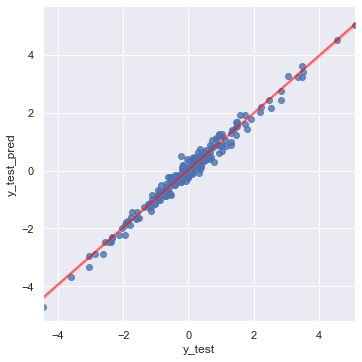

In [8]:
y_test_pred = model.predict(X_test)
compute_metrics(y_test, y_test_pred)

_ = sns.lmplot(
    y="y_test_pred",
    x="y_test",
    data=pd.DataFrame({"y_test": y_test, "y_test_pred": y_test_pred}),
    line_kws={"color": "red", "alpha": 0.5}
)

Not bad!

## Save Model to Cloud Object Storage

In [9]:
# persist trained model locally 
joblib.dump(model, "model.joblib")

# upload trained model to AWS S3
s3_client = aws.client('s3')
s3_client.upload_file(
    "model.joblib",
    AWS_S3_PROJECT_BUCKET,
    "models/model.joblib"
)

# remove local files
os.remove("model.joblib")

## Send Datasets to Aporia

To use for monitoring live prediction performance.

In [ ]:
# aporia.init(token="MYTOKEN", environment="training")

# apr_model = aporia.create_model_version(
#     model_id="bodywork-prod",
#     model_version="v1",
#     model_type="regression",
#     features={"f1": "numeric", "f2": "string"},
#     predictions={"y_pred": "numeric"},
# )

# apr_model.log_training_set(
#   features=y_train,
#   labels=X_train,
# )

# apr_model.log_test_set(
#   features=y_test,
#   labels=X_test,
# )